In [5]:
import random
import numpy as np
import pygame
from scipy.stats import norm
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# tworzymy obiekt typu pygame
pygame.init()
pygame.mixer.init()

# kolory
GREEN = (0, 255, 0)
RED = (255, 0, 0)

In [4]:
class Pijak(pygame.sprite.Sprite):
    """ klasa pijak, przyjmująca jako argument prędkość v"""
    
    def __init__(self, v):
        pygame.sprite.Sprite.__init__(self)
        self.image = pygame.Surface((20, 1))
        self.image.fill(GREEN)
        self.rect = self.image.get_rect()
        self.rect.x = 0
        self.rect.y = 49
        self.Wt_x = [0]
        self.Wt_y = [49]
        self.v = v
    
    def update_pijaka(self, dt):
        """metoda w klasie Pijak umożliwiająca ruch pijaka zgodnie z procesem Wienera przyjmująca jako argument rozdzielczość czasu dt"""
        x_pos = self.Wt_x[-1] + np.sqrt(dt) * norm.rvs(0, 1) + dt * self.v
        y_pos = self.Wt_y[-1] + np.sqrt(dt) * norm.rvs(0, 1)

        self.Wt_x.append(abs(x_pos))
        self.rect.x = abs(x_pos)

        if y_pos > 49 or y_pos < 0:
            while True:
                if y_pos > 49:
                    y_pos = 2 * 49 - y_pos
                elif y_pos < 0:
                    y_pos = -y_pos

                if y_pos <= 49 and y_pos >= 0:
                    self.rect.y = y_pos
                    self.Wt_y.append(y_pos)
                    break

        else:
            self.rect.y = y_pos
            self.Wt_y.append(y_pos)


In [5]:
def mpp(A, T):
    """funkcja zwracająca wartości mieszanego procesu poissona dla zadanej lambdy A i horyzontu czasowego T"""
    n = np.random.poisson(A * T)
    U_n = [round(random.uniform(0, T)) for i in range(0, n)]  # zaokrąglamy nasze wyniki na potrzeby pygame do jedności
    U_n = sorted(U_n)
    U_n = set(U_n)  # usuwamy wszystkie duplikaty z listy, po to żeby nie robiły nam się podwójne auta
    U_n = list(U_n)
    return U_n

class Auto_l(pygame.sprite.Sprite):
    """ klasa Auto_l przyjmująca jako argumenty d- pozycję pojawienia się na ekranie
    v_m- prędkość minimalną auta, v_M- prędkośc maksymalną"""
    
    
    def __init__(self, d, v_m, v_M):
        pygame.sprite.Sprite.__init__(self)
        self.image = pygame.Surface((40, 1))
        self.image.fill(RED)
        self.rect = self.image.get_rect()
        self.rect.x = 0
        self.rect.y = 50 - (25 + d / 2)
        self.v = round(random.uniform(v_m, v_M))
        
    def update(self):
        """metoda umożliwiająca ruch auta"""
        self.rect.x += self.v
        if self.rect.x >= 1000:
            self.kill()


class Auto_p(pygame.sprite.Sprite):
    """ klasa Auto_p przyjmująca jako argumenty d- pozycję pojawienia się na ekranie
        v_m- prędkość minimalną auta, v_M- prędkośc maksymalną"""

    def __init__(self, d, v_m, v_M):
        pygame.sprite.Sprite.__init__(self)
        self.image = pygame.Surface((40, 1))
        self.image.fill(RED)
        self.rect = self.image.get_rect()
        self.rect.x = 970
        self.rect.y = 50 - (25 - d / 2)
        self.v = round(random.uniform(v_m, v_M))
        
    def update(self):
        """metoda umożliwiająca ruch auta"""
        self.rect.x -= self.v
        if self.rect.x <= 0:
            self.kill()

In [6]:

def analiza(dt,v_p,d,v_m,v_M,A,iterations):
    """funkcja licząca prawdopodobieństwo przeżycia auta w zależności od parametrów i ilości powtórzeń
    parametr A oznacza lambdę w mieszanym procesie poissona"""
    wynik=[]

    for i in range(iterations):
        # grupa ze wszystkimi obiektami typu Sprite (pijak,auta)
        sprites = pygame.sprite.Group()

        # grupy z autami
        auta_l = pygame.sprite.Group()
        auta_p = pygame.sprite.Group()

        # dodajemy pijaka do wszystkich obiektów
        pijak = Pijak(v_p)
        sprites.add(pijak)

        # liczymy czasy pojawienia się aut zgodnie z mieszanym procesem poissona.
        czasy_aut_l = mpp(A, 1000)
        czasy_aut_p = mpp(A, 1000)

        # tworzymy puste listy do których będziemy dodawać prędkości naszych aut
        predkosci_aut_l = []
        predkosci_aut_p = []

        k1 = 0  # indeks w czasy_aut_l
        k2 = 0  # indeks w czasy_aut_p

        v1 = 0  # indeks w predkosci_aut_l
        v2 = 0  # indeks w predkosci_aut_p

        # animacja

        running = True

        while running:
            kolizja_l = pygame.sprite.spritecollide(pijak, auta_l, False)  # sprawdzamy kolizje z autami z lewej strony
            kolizja_p = pygame.sprite.spritecollide(pijak, auta_p, False)  # sprawdzamy kolizje z autami z prawej strony

            if not kolizja_l and not kolizja_p and pijak.rect.x < 1000:  # jeśli nie występują kolizje, nasze obiekty się poruszają
                if k1 < (len(czasy_aut_l) - 1):  # sprawdzamy czy indeks listy jest mniejszy od długości listy -1
                    if pijak.rect.x == czasy_aut_l[
                        k1]:  # jeśli pozycja pijaka na osi X jest równa wartości pojawienia się auta na ekranie- dodajemy Auto z lewej strony
                        if len(predkosci_aut_l) == 0:  # przypadek jeśli jeszcze nie mamy żadnych prędkości w liście
                            l = 1
                        else:  # przypadek jeśli co najmniej jedna prędkość jest w liście
                            l = 2
                        a_lewe = Auto_l(d, v_m, v_M)  # tworzymy obiekt Auto_l
                        predkosci_aut_l.append(a_lewe.v)  # dodajemy prędkość naszego obiektu do listy z prędkościami
                        while a_lewe.v > predkosci_aut_l[
                            -l]:  # sprawdzamy czy prędkość auta wylosowanego jest większa od prędkości poprzedniego auta
                            a_lewe.v = round(random.uniform(v_m,
                                                            v_M))  # losujemy tak długo nową prędkość, aż będzie ona mniejsza równa od prędkośći poprzednika
                            predkosci_aut_l[
                                v1] = a_lewe.v  # jeśli tak jest, zastępujemy wcześniej dodaną wartość w linijce 172 na wartość poprawną
                        sprites.add(a_lewe)
                        auta_l.add(a_lewe)
                        k1 += 1
                        v1 += 1

                if k2 < (len(czasy_aut_p) - 1):  # analogicznie jak wyżej
                    if pijak.rect.x == czasy_aut_p[k2]:
                        if len(predkosci_aut_p) == 0:
                            l = 1
                        else:
                            l = 2
                        k2 += 1
                        a_prawe = Auto_p(d, v_m, v_M)

                        predkosci_aut_p.append(a_prawe.v)
                        while a_prawe.v > predkosci_aut_p[-l]:
                            a_prawe.v = round(random.uniform(v_m, v_M))
                            predkosci_aut_p[v2] = a_prawe.v
                        sprites.add(a_prawe)
                        auta_p.add(a_prawe)
                        k2 += 1
                        v2 += 1

                # update ruchów naszych obiektów
                pijak.update_pijaka(dt)
                auta_l.update()
                auta_p.update()

                # sprawdzamy czy na ekranie są jeszcze jakieś auta poruszające się od lewej strony, jeśli nie- czyścimy wartości prędkości w liście
                if len(auta_l) == 0:
                    predkosci_aut_l = []
                    v1 = 0
                # analogicznie z autami z prawej strony
                if len(auta_p) == 0:
                    predkosci_aut_p = []
                    v2 = 0

            if kolizja_l or kolizja_p:
                wynik.append(0)
                running = False
            if pijak.rect.x>=1000:
                wynik.append(1)
                running = False

    return sum(wynik)/iterations



# domyślne wartości:
# dt = 0.1
# v_p = 2
# v_m = 3
# v_M = 9
# A = 1
# d = 10



# Badanie prawdopodobieństwa przeżycia w zależności od parametru d

In [35]:
dt = 0.1
v_p = 2  
v_m = 3  
v_M = 9
A = 1
ds=[i for i in range(5,16)]
ys=[]

for d in ds:
    ys.append(analiza(dt,v_p,d,v_m,v_M,A,1000))
    

C:\Users\Kuba\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


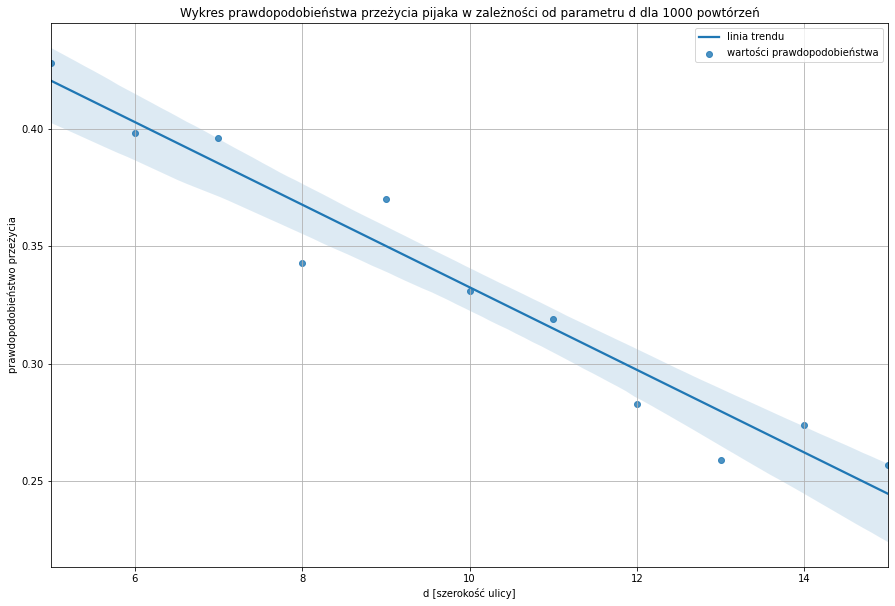

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Wykres prawdopodobieństwa przeżycia pijaka w zależności od parametru d dla 1000 powtórzeń")
ax.set_xlabel('d [szerokość ulicy]')
ax.set_ylabel('prawdopodobieństwo przeżycia')
ax.grid()

sns.regplot(ds,ys)
ax.legend(["linia trendu","wartości prawdopodobieństwa"])


plt.show()

# Badanie prawdopodobieństwa przeżycia w zależności od rozkładów N_t i M_t
# (Parametru A)

In [31]:
dt = 0.1
v_p = 2
v_m = 3
v_M = 9
As = np.linspace(0.5,1,11)
d = 10
ys=[]

for A in As:
    ys.append(analiza(dt,v_p,d,v_m,v_M,A,1000))

In [11]:
# dla V: ys = [0.007, 0.025, 0.029, 0.053, 0.074, 0.104, 0.154, 0.195, 0.257, 0.276, 0.321], vs = np.linspace(0.5,2,11)
# dla A: ys = [0.269, 0.242, 0.302, 0.293, 0.285, 0.297, 0.313, 0.304, 0.317, 0.304, 0.308], As = np.linspace(0.5,1,11)

C:\Users\Kuba\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


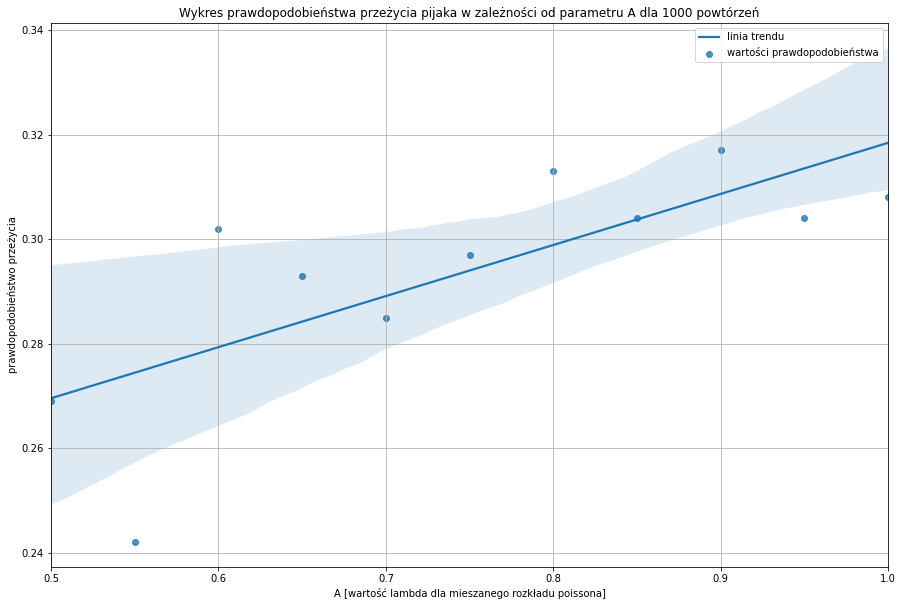

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Wykres prawdopodobieństwa przeżycia pijaka w zależności od parametru A dla 1000 powtórzeń")
ax.set_xlabel('A [wartość lambda dla mieszanego rozkładu poissona]')
ax.set_ylabel('prawdopodobieństwo przeżycia')
ax.grid()


sns.regplot(As,ys)
ax.legend(["linia trendu","wartości prawdopodobieństwa"])



plt.show()

## Badanie prawdopodobieństwa przeżycia w zależności od v pijaka

In [20]:
dt = 0.1
vs=np.linspace(0.5,2,11)
v_m = 3
v_M = 9
A = 1
d = 10
ys=[]

for v in vs:
    ys.append(analiza(dt,v,d,v_m,v_M,A,1000))

C:\Users\Kuba\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


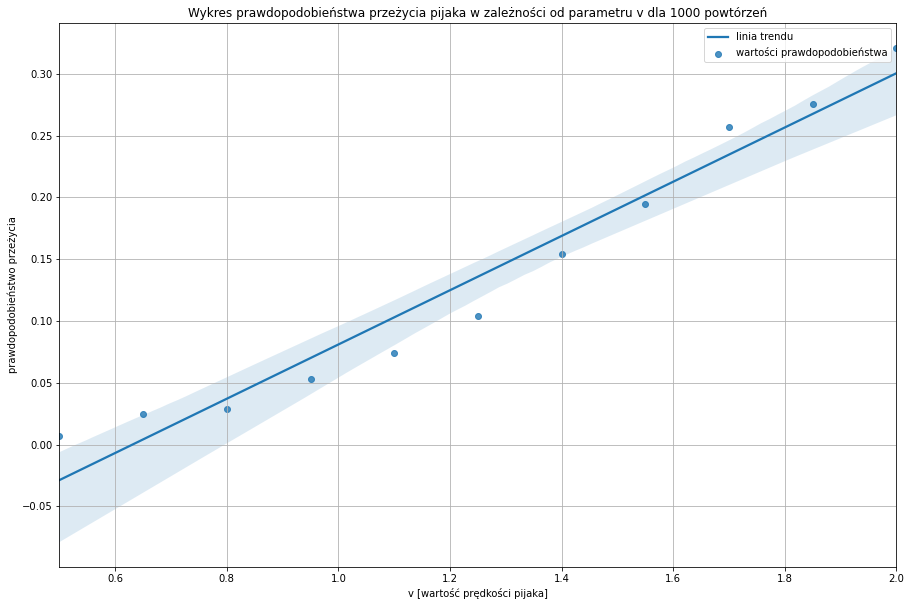

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Wykres prawdopodobieństwa przeżycia pijaka w zależności od parametru v dla 1000 powtórzeń")
ax.set_xlabel('v [wartość prędkości pijaka]')
ax.set_ylabel('prawdopodobieństwo przeżycia')
ax.grid()

sns.regplot(vs,ys)
ax.legend(["linia trendu","wartości prawdopodobieństwa"])


plt.show()

## Badanie prawdopodobieństwa przeżycia w zależności od vm

In [10]:
dt = 0.1
vs=np.linspace(3,9,11)
#v_m = 3
vp=2
v_M = 9
A = 1
d = 10
ys=[]

for v in vs:
    ys.append(analiza(dt,vp,d,v,v_M,A,1000))

/home/norbert/projektjupyter/projekt_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


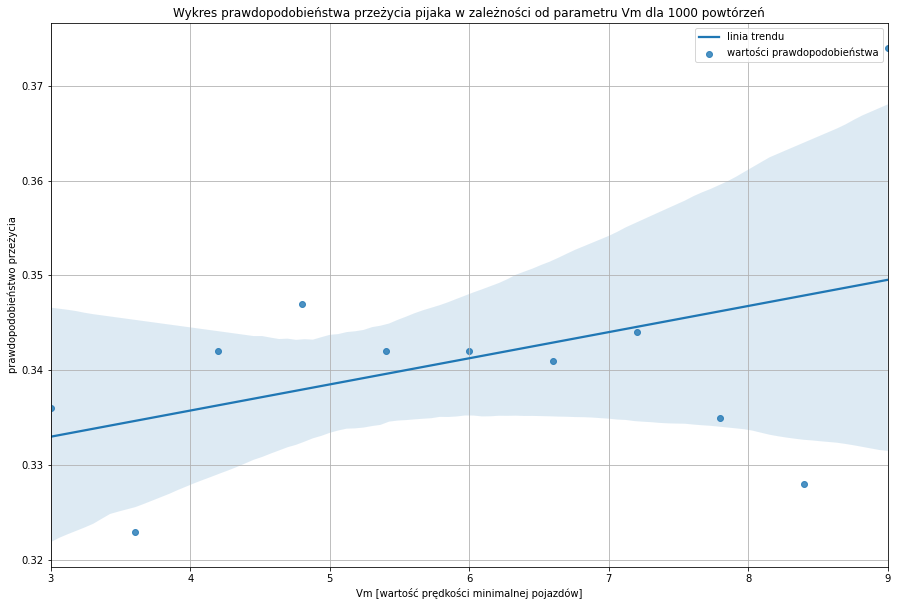

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Wykres prawdopodobieństwa przeżycia pijaka w zależności od parametru Vm dla 1000 powtórzeń")
ax.set_xlabel('Vm [wartość prędkości minimalnej pojazdów]')
ax.set_ylabel('prawdopodobieństwo przeżycia')
ax.grid()

sns.regplot(vs,ys)
ax.legend(["linia trendu","wartości prawdopodobieństwa"])


plt.show()

## Badanie prawdopodobieństwa przeżycia w zależności od vM

In [7]:
dt = 0.1
vs=np.linspace(9,20,11)
v_m = 3
v_M = 9
vp=2
A = 1
d = 10
ys=[]

for v in vs:
    ys.append(analiza(dt,vp,d,v_m,v,A,1000))

/home/norbert/projektjupyter/projekt_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


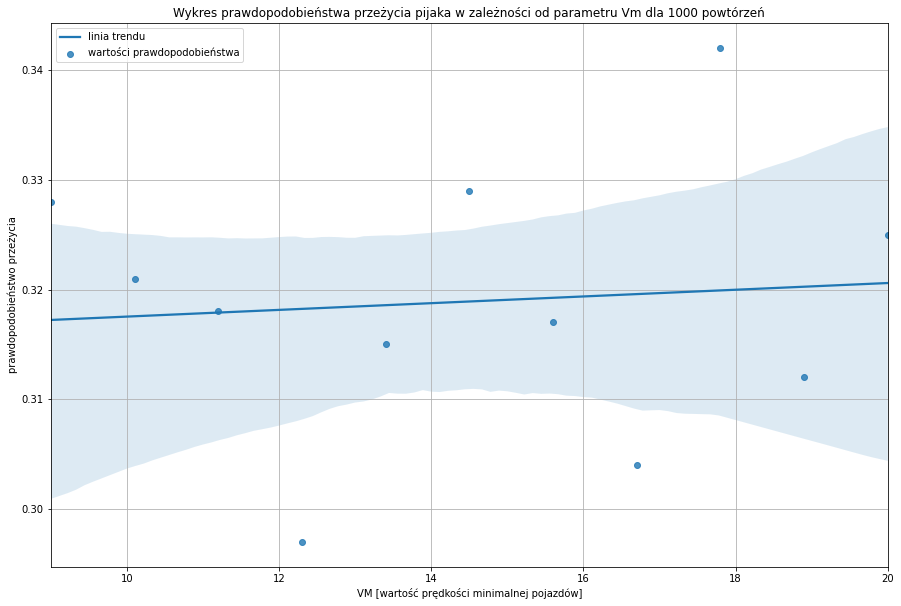

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Wykres prawdopodobieństwa przeżycia pijaka w zależności od parametru Vm dla 1000 powtórzeń")
ax.set_xlabel('VM [wartość prędkości minimalnej pojazdów]')
ax.set_ylabel('prawdopodobieństwo przeżycia')
ax.grid()

sns.regplot(vs,ys)
ax.legend(["linia trendu","wartości prawdopodobieństwa"])


plt.show()

# Program z gui pozwalającym dobierać parametry

### Żeby program zadziałał należy zrobić upload dwoch plików tlo.jpg, stop.jpg 

In [1]:
import pygame_gui
import random
import sys
import numpy as np
import pygame
from scipy.stats import norm
from PIL import Image
import glob
import os

pygame.init()

pygame.display.set_caption('pijak')

calyekran = pygame.display.set_mode((1000, 500))
tlo = pygame.image.load('tlo.jpg')
tlo = pygame.transform.scale(tlo, (1000, 500))
calyekran.blit(tlo, (0, 0))

win = pygame.Surface((400, 400))
win.fill((255, 255, 255))
calyekran.blit(win, (550, 50))

screen = pygame.Surface((1000, 50))
window_surface = pygame.Surface((500, 500))

# do wychodzenia
stop = pygame.image.load('stop.jpg')
stop = pygame.transform.scale(stop, (100, 50))


def pijakfunkcja(dt, vp, djd, vm, vM):
    # szerokość i wysokość okienka w pygame, oraz liczba fpsów

    FPS = 1000

    # tworzymy obiekt typu pygame
    pygame.init()
    pygame.mixer.init()

    pygame.display.set_caption("Pijak")

    # przycisk stopu
    rect = stop.get_rect()
    rect.center = (200, 25)

    clock = pygame.time.Clock()
    clock.tick(FPS)

    # kolory
    GREEN = (0, 255, 0)
    WHITE = (255, 255, 255)
    RED = (255, 0, 0)

    def mpp(A, T):
        """funkcja zwracająca wartości mieszanego procesu poissona dla zadanej lambdy A i horyzontu czasowego T"""
        n = np.random.poisson(A * T)
        U_n = [round(random.uniform(0, T)) for i in
               range(0, n)]  # zaokrąglamy nasze wyniki na potrzeby pygame do jedności
        U_n = sorted(U_n)
        U_n = set(U_n)  # usuwamy wszystkie duplikaty z listy, po to żeby nie robiły nam się podwójne auta
        U_n = list(U_n)
        return U_n

    class Pijak(pygame.sprite.Sprite):
        """ klasa pijak, przyjmująca jako argument prędkość v"""

        def __init__(self, v):
            pygame.sprite.Sprite.__init__(self)
            self.image = pygame.Surface((20, 1))
            self.image.fill(GREEN)
            self.rect = self.image.get_rect()
            self.rect.x = 0
            self.rect.y = 49
            self.Wt_x = [0]
            self.Wt_y = [49]
            self.v = v

        def update_pijaka(self, dt):
            """metoda w klasie Pijak umożliwiająca ruch pijaka zgodnie z procesem Wienera przyjmująca jako argument rozdzielczość czasu dt"""
            x_pos = self.Wt_x[-1] + np.sqrt(dt) * norm.rvs(0, 1) + dt * self.v
            y_pos = self.Wt_y[-1] + np.sqrt(dt) * norm.rvs(0, 1)

            self.Wt_x.append(abs(x_pos))
            self.rect.x = abs(x_pos)

            if y_pos > 49 or y_pos < 0:
                while True:
                    if y_pos > 49:
                        y_pos = 2 * 49 - y_pos
                    elif y_pos < 0:
                        y_pos = -y_pos

                    if y_pos <= 49 and y_pos >= 0:
                        self.rect.y = y_pos
                        self.Wt_y.append(y_pos)
                        break

            else:
                self.rect.y = y_pos
                self.Wt_y.append(y_pos)

    class Auto_l(pygame.sprite.Sprite):
        """ klasa Auto_l przyjmująca jako argumenty d- pozycję pojawienia się na ekranie
        v_m- prędkość minimalną auta, v_M- prędkośc maksymalną"""

        def __init__(self, d, v_m, v_M):
            pygame.sprite.Sprite.__init__(self)
            self.image = pygame.Surface((40, 1))
            self.image.fill(RED)
            self.rect = self.image.get_rect()
            self.rect.x = 0
            self.rect.y = 50 - (25 + d / 2)
            self.v = round(random.uniform(v_m, v_M))

        def update(self):
            """metoda umożliwiająca ruch auta"""
            self.rect.x += self.v
            if self.rect.x >= 1000:
                self.kill()

    class Auto_p(pygame.sprite.Sprite):
        """ klasa Auto_p przyjmująca jako argumenty d- pozycję pojawienia się na ekranie
            v_m- prędkość minimalną auta, v_M- prędkośc maksymalną"""

        def __init__(self, d, v_m, v_M):
            pygame.sprite.Sprite.__init__(self)
            self.image = pygame.Surface((40, 1))
            self.image.fill(RED)
            self.rect = self.image.get_rect()
            self.rect.x = 970
            self.rect.y = 50 - (25 - d / 2)
            self.v = round(random.uniform(v_m, v_M))

        def update(self):
            """metoda umożliwiająca ruch auta"""
            self.rect.x -= self.v
            if self.rect.x <= 0:
                self.kill()

    # grupa ze wszystkimi obiektami typu Sprite (pijak,auta)
    sprites = pygame.sprite.Group()

    # grupy z autami
    auta_l = pygame.sprite.Group()
    auta_p = pygame.sprite.Group()

    # dodajemy pijaka do wszystkich obiektów
    pijak = Pijak(vp)
    sprites.add(pijak)

    # liczymy czasy pojawienia się aut zgodnie z mieszanym procesem poissona.
    czasy_aut_l = mpp(1, 1000)
    czasy_aut_p = mpp(1, 1000)

    # tworzymy puste listy do których będziemy dodawać prędkości naszych aut
    predkosci_aut_l = []
    predkosci_aut_p = []

    # parametry
    dt = dt  # krok czasowy

    k1 = 0  # indeks w czasy_aut_l
    k2 = 0  # indeks w czasy_aut_p

    v1 = 0  # indeks w predkosci_aut_l
    v2 = 0  # indeks w predkosci_aut_p

    d = djd  # zadana dlugosc jezdni

    v_m = vm  # prędkość minimalna
    v_M = vM  # prędkość maksymalna
    running = True
    i = 0
    while running:
        screen.fill(WHITE)
        # do kolizji przycisku
        wychodzenie = pygame.Rect(700, 50, 100, 50)
        # pygame.image.save(win, "z"+str(i)+".jpeg")
        kolizja_l = pygame.sprite.spritecollide(pijak, auta_l, False)  # sprawdzamy kolizje z autami z lewej strony
        kolizja_p = pygame.sprite.spritecollide(pijak, auta_p, False)  # sprawdzamy kolizje z autami z prawej strony

        if not kolizja_l and not kolizja_p and pijak.rect.x < 1000:  # jeśli nie występują kolizje, nasze obiekty się poruszają,oraz pozycja pijaka jest mniejsz od 1000

            if k1 < (len(czasy_aut_l) - 1):  # sprawdzamy czy indeks listy jest mniejszy od długości listy -1
                if pijak.rect.x >= czasy_aut_l[
                    k1]:  # jeśli pozycja pijaka na osi X jest równa wartości pojawienia się auta na ekranie- dodajemy Auto z lewej strony
                    if len(predkosci_aut_l) == 0:  # przypadek jeśli jeszcze nie mamy żadnych prędkości w liście
                        l = 1
                    else:  # przypadek jeśli co najmniej jedna prędkość jest w liście
                        l = 2
                    a_lewe = Auto_l(d, v_m, v_M)  # tworzymy obiekt Auto_l
                    predkosci_aut_l.append(a_lewe.v)  # dodajemy prędkość naszego obiektu do listy z prędkościami
                    while a_lewe.v > predkosci_aut_l[
                        -l]:  # sprawdzamy czy prędkość auta wylosowanego jest większa od prędkości poprzedniego auta
                        a_lewe.v = round(random.uniform(v_m,
                                                        v_M))  # losujemy tak długo nową prędkość, aż będzie ona mniejsza równa od prędkośći poprzednika
                        predkosci_aut_l[
                            v1] = a_lewe.v  # jeśli tak jest, zastępujemy wcześniej dodaną wartość w linijce 172 na wartość poprawną
                    sprites.add(a_lewe)
                    auta_l.add(a_lewe)
                    k1 += 1
                    v1 += 1

            if k2 < (len(czasy_aut_p) - 1):  # analogicznie jak wyżej
                if pijak.rect.x >= czasy_aut_p[k2]:
                    if len(predkosci_aut_p) == 0:
                        l = 1
                    else:
                        l = 2
                    k2 += 1
                    a_prawe = Auto_p(d, v_m, v_M)

                    predkosci_aut_p.append(a_prawe.v)
                    while a_prawe.v > predkosci_aut_p[-l]:
                        a_prawe.v = round(random.uniform(v_m, v_M))
                        predkosci_aut_p[v2] = a_prawe.v
                    sprites.add(a_prawe)
                    auta_p.add(a_prawe)
                    k2 += 1
                    v2 += 1
                    # print(predkosci_aut_p)

            # rysujemy okno i nasze obiekty w oknie, oraz skalujemy obraz
            clock.tick(FPS)

            sprites.draw(screen)

            win.blit(pygame.transform.scale(screen, win.get_rect().size), (0, 0))
            pygame.image.save(win, "z" + str(i) + ".png")
            win.blit(stop, rect)
            calyekran.blit(win, (550, 50))
            # update ruchów naszych obiektów

            pijak.update_pijaka(dt)
            auta_l.update()
            auta_p.update()

            # sprawdzamy czy na ekranie są jeszcze jakieś auta poruszające się od lewej strony, jeśli nie- czyścimy wartości prędkości w liście
            if len(auta_l) == 0:
                predkosci_aut_l = []
                v1 = 0
            # analogicznie z autami z prawej strony
            if len(auta_p) == 0:
                predkosci_aut_p = []
                v2 = 0
        else:
            gui()
        # przerwanie programu jeśli zamkniemy okienko

        # pozycja kursora
        mx, my = pygame.mouse.get_pos()
        click = False
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                imgs = sorted(glob.glob('*.png'), key=os.path.getmtime)
                for i in imgs:
                    os.remove(i)
                pygame.quit()
                sys.exit()
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    click = True
            if wychodzenie.collidepoint((mx, my)):
                if click:
                    gui()

        pygame.display.flip()
        pygame.display.update()
        # pygame.image.save(win, "z" + str(i) + ".jpeg")
        i += 1
    pygame.quit()


def gui():
    manager = pygame_gui.UIManager((500, 500))

    # start przycisk
    jazda = pygame_gui.elements.UIButton(relative_rect=pygame.Rect((350, 400), (100, 50)),
                                         text='Start',
                                         manager=manager)

    # gif przycisk
    gifownik = pygame_gui.elements.UIButton(relative_rect=pygame.Rect((350, 250), (100, 50)),
                                            text='GIF',
                                            manager=manager)

    # labele entryboxów
    dtl = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((25, 75), (150, 20)), manager=manager,
                                               text="dt")
    vpl = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((25, 150), (150, 20)), manager=manager,
                                               text="Prędkość pijaka")
    djdl = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((25, 225), (150, 20)), manager=manager,
                                                text="Szerokość drogi d")
    vml = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((25, 300), (150, 20)), manager=manager,
                                               text="Vm samochodów")
    vMl = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((25, 375), (150, 20)), manager=manager,
                                               text="VM samochodów")
    # legenda

    lgd1 = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((200, 25), (300, 25)), manager=manager,
                                                text="dt- dodatnia liczba rzeczywista")
    lgd2 = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((200, 50), (300, 25)), manager=manager,
                                                text="prędkość pijaka z przedziału (0.5,2)")
    lgd3 = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((200, 75), (300, 25)), manager=manager,
                                                text="d-liczby całkowite z [5,15]")
    lgd4 = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((200, 100), (300, 25)), manager=manager,
                                                text="Vm-dowolne liczby naturalne")
    lgd5 = pygame_gui.elements.ui_label.UILabel(relative_rect=pygame.Rect((200, 125), (300, 25)), manager=manager,
                                                text="VM-dowolne liczby naturalne")

    # entryboxy
    # dt wprowadzanie
    wprowadzacz = pygame_gui.elements.UITextEntryLine(relative_rect=pygame.Rect((50, 100), (100, 50)), manager=manager)
    # vp wprowadzanie
    wprowadzacz1 = pygame_gui.elements.UITextEntryLine(relative_rect=pygame.Rect((50, 175), (100, 50)),
                                                       manager=manager)
    # d jak droga wprowadzanie
    wprowadzacz2 = pygame_gui.elements.UITextEntryLine(relative_rect=pygame.Rect((50, 250), (100, 50)),
                                                       manager=manager)
    # vm predkosc min wprowadzanie
    wprowadzacz3 = pygame_gui.elements.UITextEntryLine(relative_rect=pygame.Rect((50, 325), (100, 50)),
                                                       manager=manager)
    # vM predkosc max wprowadzanie
    wprowadzacz4 = pygame_gui.elements.UITextEntryLine(relative_rect=pygame.Rect((50, 400), (100, 50)),
                                                       manager=manager)

    clock = pygame.time.Clock()

    is_running = True
    while is_running:
        time_delta = clock.tick(60) / 1000.0
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                is_running = False
                imgs = sorted(glob.glob('*.png'), key=os.path.getmtime)
                for i in imgs:
                    os.remove(i)
                pygame.quit()
                sys.exit()
            if event.type == pygame.USEREVENT:
                if event.user_type == pygame_gui.UI_BUTTON_PRESSED:
                    if event.ui_element == jazda:
                        dt = wprowadzacz.get_text()
                        vp = wprowadzacz1.get_text()
                        djd = wprowadzacz2.get_text()
                        vm = wprowadzacz3.get_text()
                        vM = wprowadzacz4.get_text()
                        vp = float(vp)
                        dt = float(dt)
                        djd = int(djd)
                        vm = int(vm)
                        vM = int(vM)
                        pijakfunkcja(dt, vp, djd, vm, vM)
                    if event.ui_element == gifownik:
                        gif()
            manager.process_events(event)

        manager.update(time_delta)
        manager.draw_ui(calyekran)
        pygame.display.update()
        pygame.display.flip()


def gif():
    frames = []

    imgs = sorted(glob.glob('*.png'), key=os.path.getmtime)

    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    frames[0].save('ruchpijak.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=10, loop=0)

    for i in imgs:
        os.remove(i)


gui()

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


SystemExit: 

C:\Users\Kuba\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
